# Tutorial - Reading RAW images with python
This is a short tutorial on how to read images from the camera at the UTSC Observatory with python. 

We use numpy, scipy, and matplotlib throughout the course. You probably have those installed already, if not, install them, for example with pip: `pip install numpy scipy matplotlib`. 

The UTSC observatory uses a regular DSLR camera (without the IR filter). We use the RAW data format for images. To read these files, you need to install [rawkit](https://rawkit.readthedocs.io/en/latest/). The simplest way to do this is with pip: `pip install rawkit`. 

We also use the python image library [Pillow](https://pillow.readthedocs.io/en/4.2.x/) (a PIL fork). You can once again install it with `pip install Pillow`.

I'd also encourage you to install [mpldatacursor](https://github.com/joferkington/mpldatacursor) which will become useful when you try to get the pixel coordinates of a star. You can probably guess how to install it now: with `pip install mpldatacursor`.

Once you have installed all packages, you can import them as follows:

In [1]:
from rawkit.raw import Raw
import numpy as np
from mpldatacursor import datacursor
import warnings,glob
from PIL import Image
import scipy
import scipy.misc
%matplotlib nbagg
import matplotlib.pyplot as plt

We can read in one file with the following code. This may take a second or two depending on the speed of your computer.

In [2]:
filename = "full_00046_iso400_shutter30s.cr2"
with Raw(filename=filename) as raw:
    nebula, cdesc = raw.bayer_data(include_margin=False)

We convert the image to a numpy array. This will make it easier for us to work with. Note that the datatype of the numpy array will be `int64` (i.e. not `float`).

In [3]:
nebula = np.array(nebula)

Let's have a quick look what the picture looks like. To do that we need to set the range of pixel values to something meaningful. Here, we just choose to show everything between 1% and 99.9%. This will saturate all hot pixels and very bright star.

In [4]:
cmin=np.percentile(nebula,1.)
cmax=np.percentile(nebula,99.9)

The raw image contains separate red, green, and blue channels, representing the Bayer mask on the sensor. For now, let's just plot the blue channel with the `[::2,::2]` syntax (selecting every second column and row). 

<IPython.core.display.Javascript object>


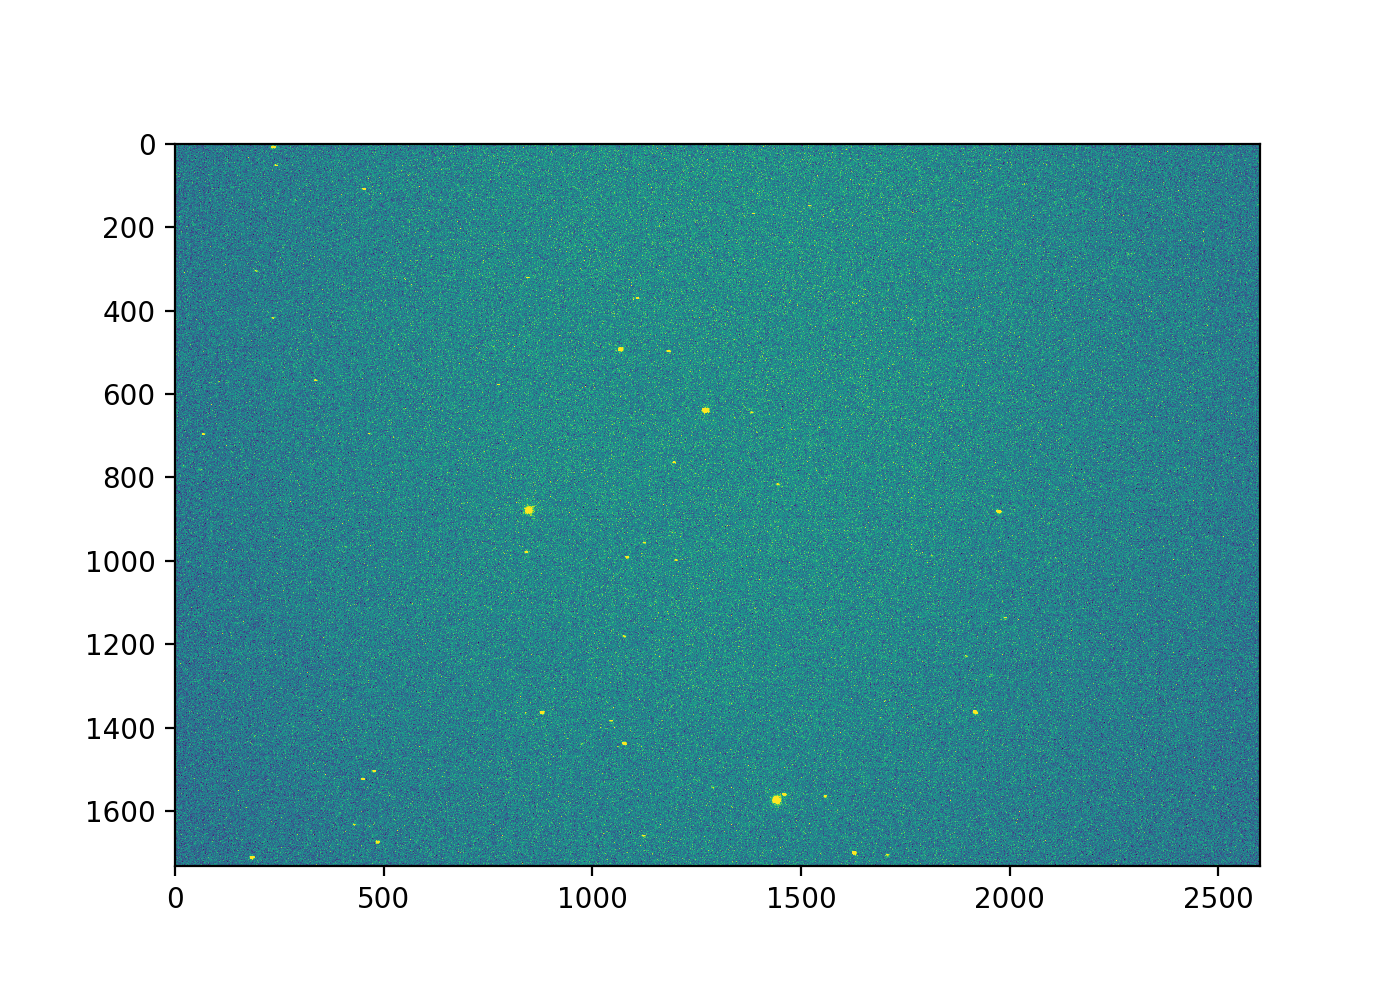

In [5]:
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(nebula[::2,::2], clim=[cmin,cmax], cmap="viridis");

If we want an actual color image, we need to combine the different channels in a meaningful way. But first note that the different channels have a different size:

In [6]:
nebula[::2,::2].shape, nebula[1::2,::2].shape, nebula[::2,1::2].shape, nebula[1::2,1::2].shape

((1733, 2601), (1732, 2601), (1733, 2601), (1732, 2601))

For simplicity, we'll simply discard the last row in two of the four channels. Then every channel has the same length. In case you wonder why there are four channels for RGB data. Well, there are two channels for green. Here, we'll simply add them.

In [7]:
red = nebula[:-1:2,::2]
green1 = nebula[1::2,::2]
green2 = nebula[:-1:2,1::2]
blue = nebula[1::2,1::2]
green = green1+green2

We'll now do some rescaling and it might make sense to convert the arrays to floating point numbers. Note that whenevr you work with floating point numbers, operations will make you loose information and the image quality might get worse.

In [8]:
red = red.astype(float)
blue = blue.astype(float)
green = green.astype(float)

To create one RGB image that we can display we need to adjust the ranges of each channel. We'll talk a bit about the details in class. Here, we do the same trick as above and scaling each channel with values given by the low and high percentiles

In [9]:
rlow, rhigh = np.percentile(red, [1,99.99])
red = (red-rlow)/(rhigh-rlow)
rlow, rhigh = np.percentile(green, [1,99.99])
green = (green-rlow)/(rhigh-rlow)
rlow, rhigh = np.percentile(blue, [1,99.99])
blue = (blue-rlow)/(rhigh-rlow)

We also clip the values between 0 and 1.

In [10]:
np.clip(red, 0., 1., out=red)
np.clip(green, 0., 1., out=green)
np.clip(blue, 0., 1., out=blue);

And then combine an RGB array.

In [11]:
rgb_nebula = np.dstack((red,green,blue))

Now we can plot the RGB image.

<IPython.core.display.Javascript object>


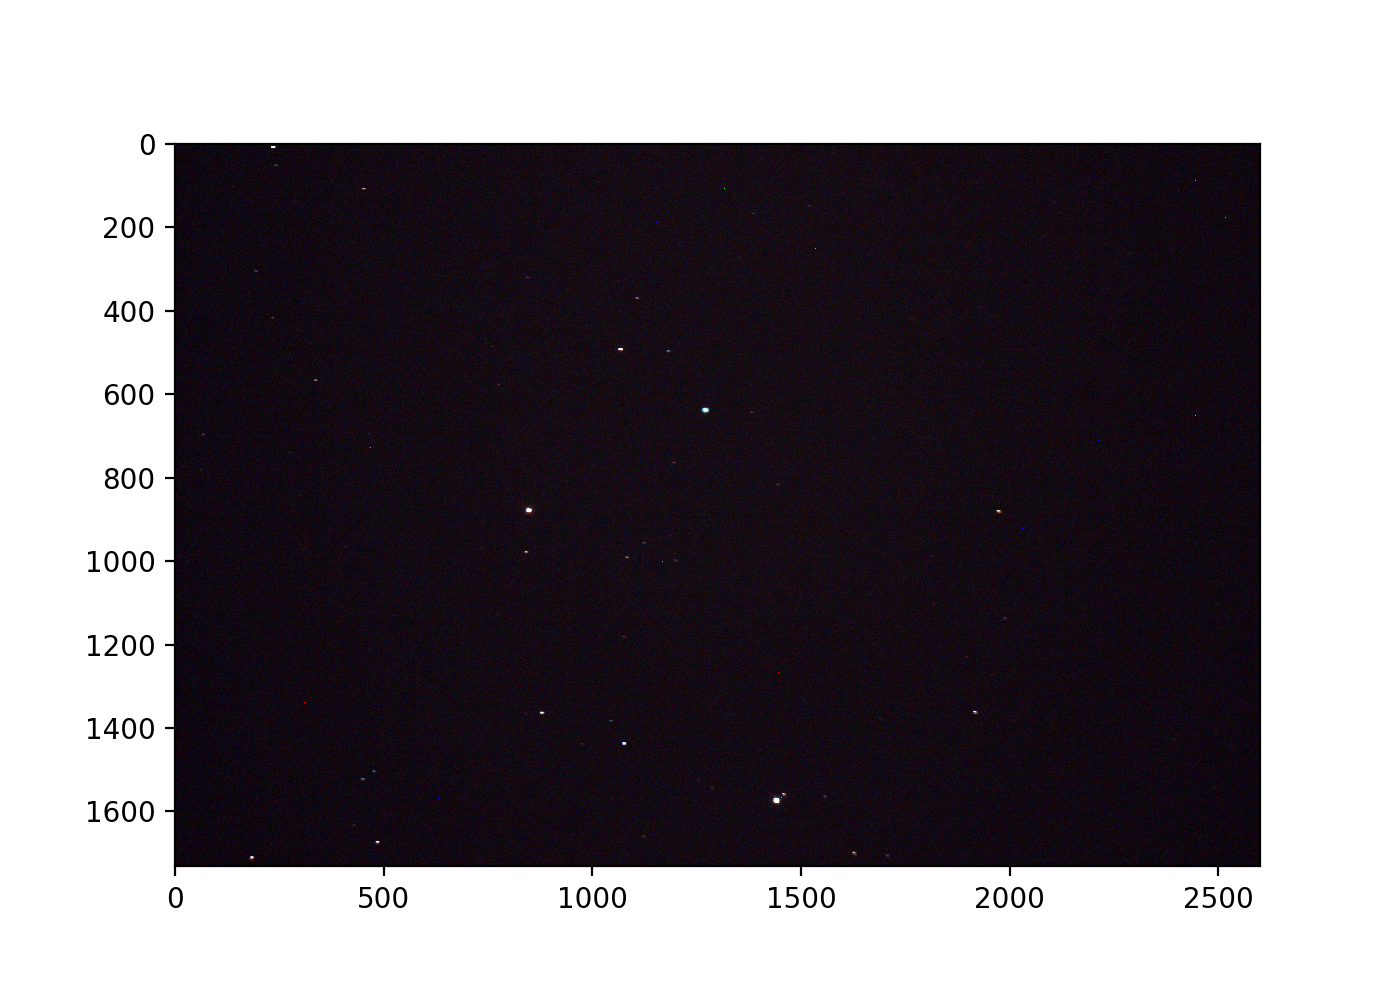

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(rgb_nebula);

Note the blueish star at $x=1300$ and $y=600$? Well, it's not a star. So let's use the datacurser to get the precise coordinates (if you're running the interactive version of this notebook click on the blue star in the plot below). Then we zoom in to that area.

<IPython.core.display.Javascript object>


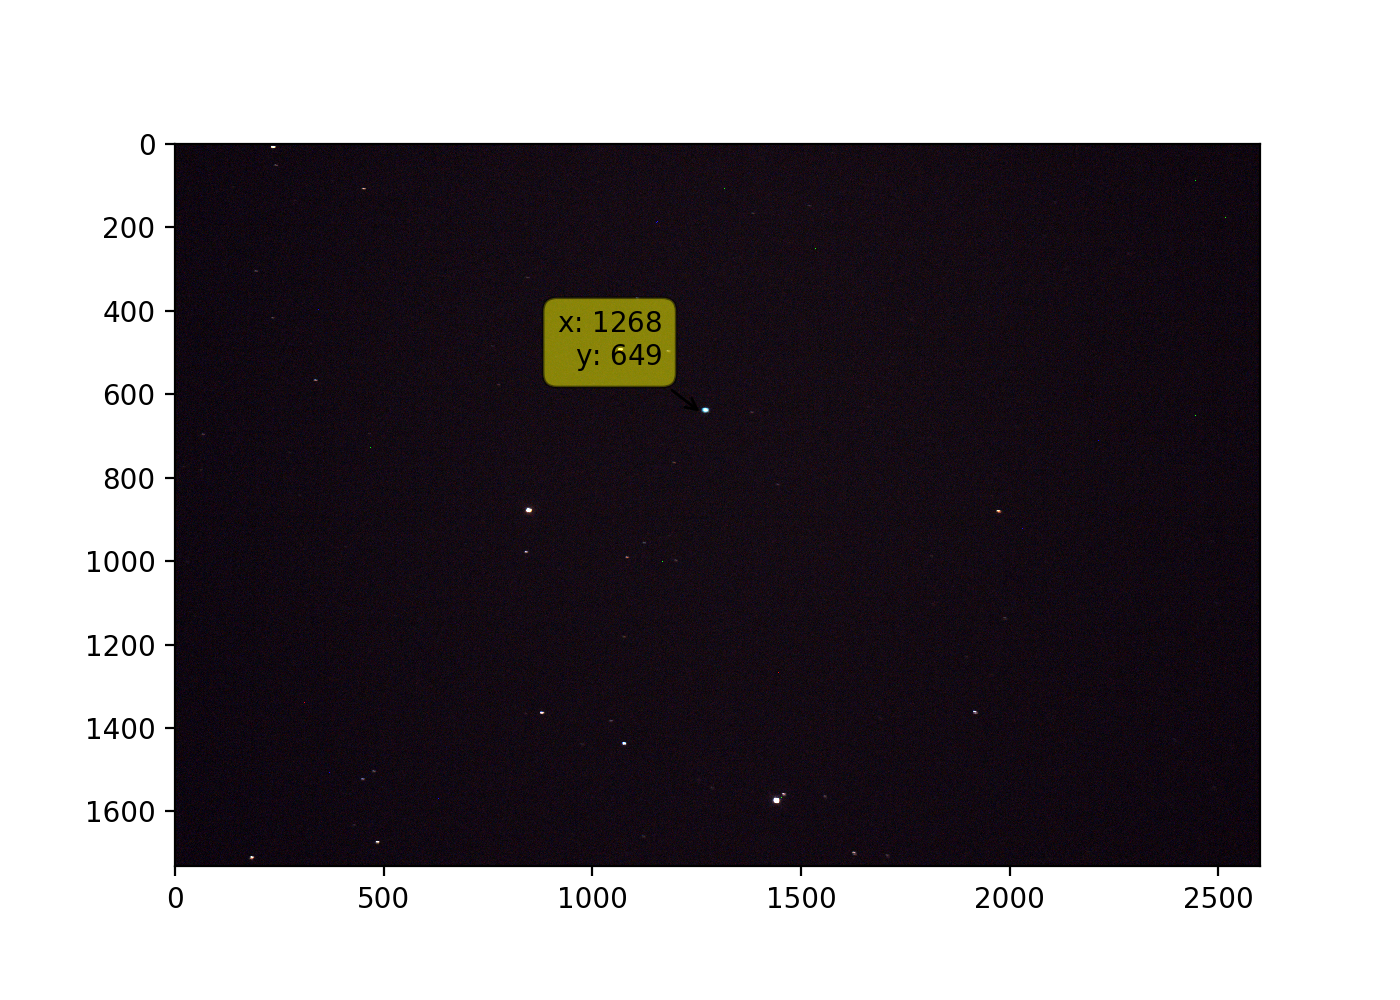

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(rgb_nebula)
dc = datacursor(ax)

The coordinates are:

In [15]:
x, y = [int(t) for t in dc.annotations[ax].xy]
x, y 

(1267, 649)

Let's zoom in to a small area around this point.

<IPython.core.display.Javascript object>


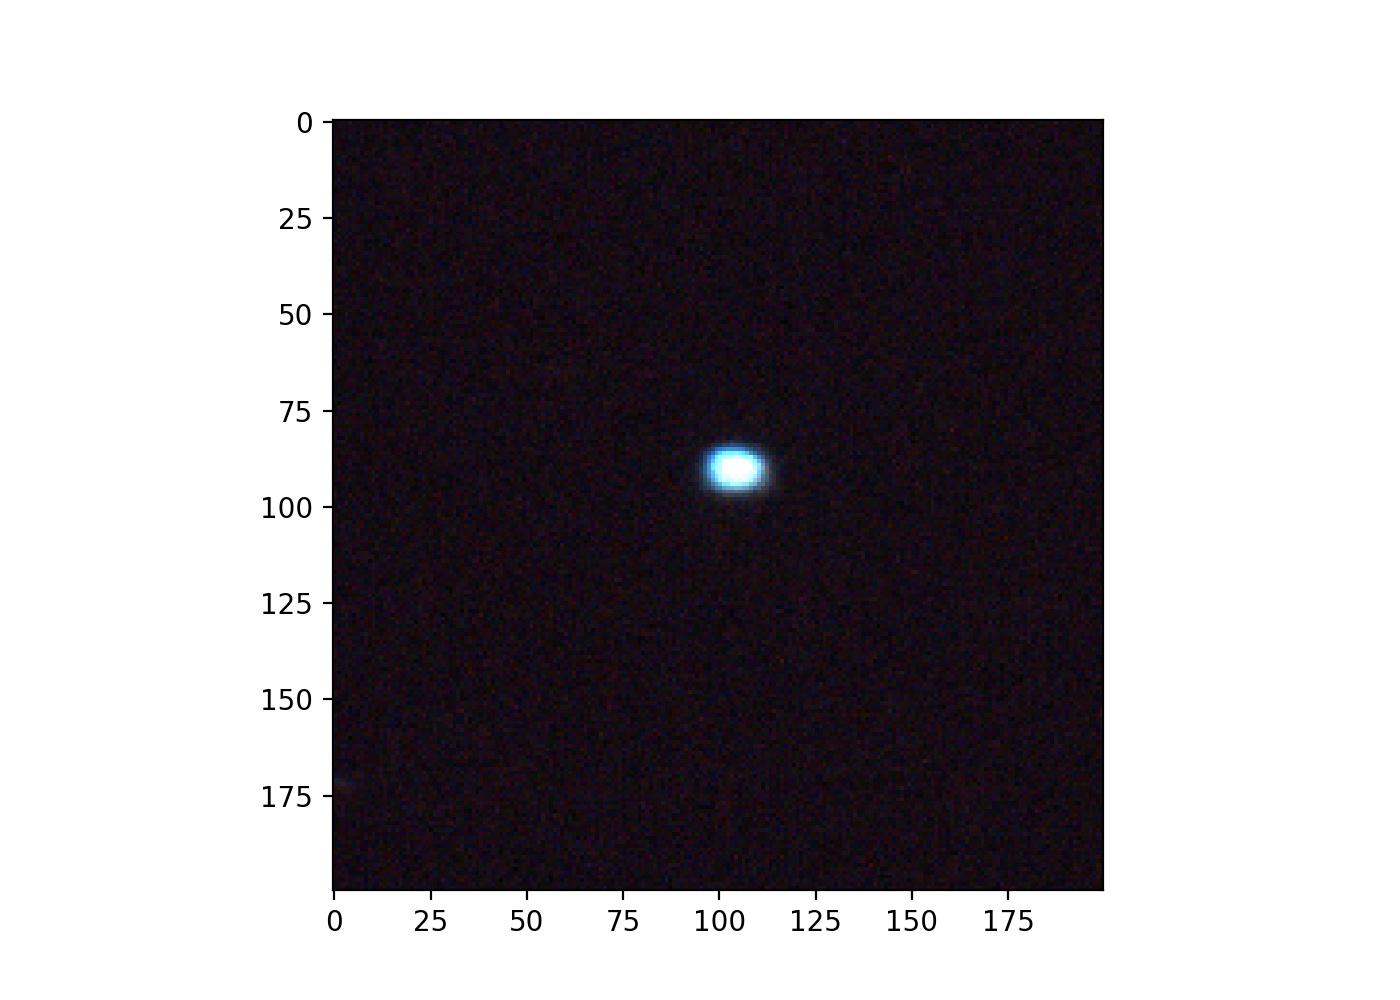

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(rgb_nebula[y-100:y+100,x-100:x+100,:]);

You can now play around with image a little. First let's create a grayscale image.

In [17]:
zoomin_gray = np.average(rgb_nebula[y-100:y+100,x-100:x+100,:],axis=2)

Next, let's change the contrast. There are many ways to do that. Here, let us just take the square root of each pixel value and plot the result.

<IPython.core.display.Javascript object>


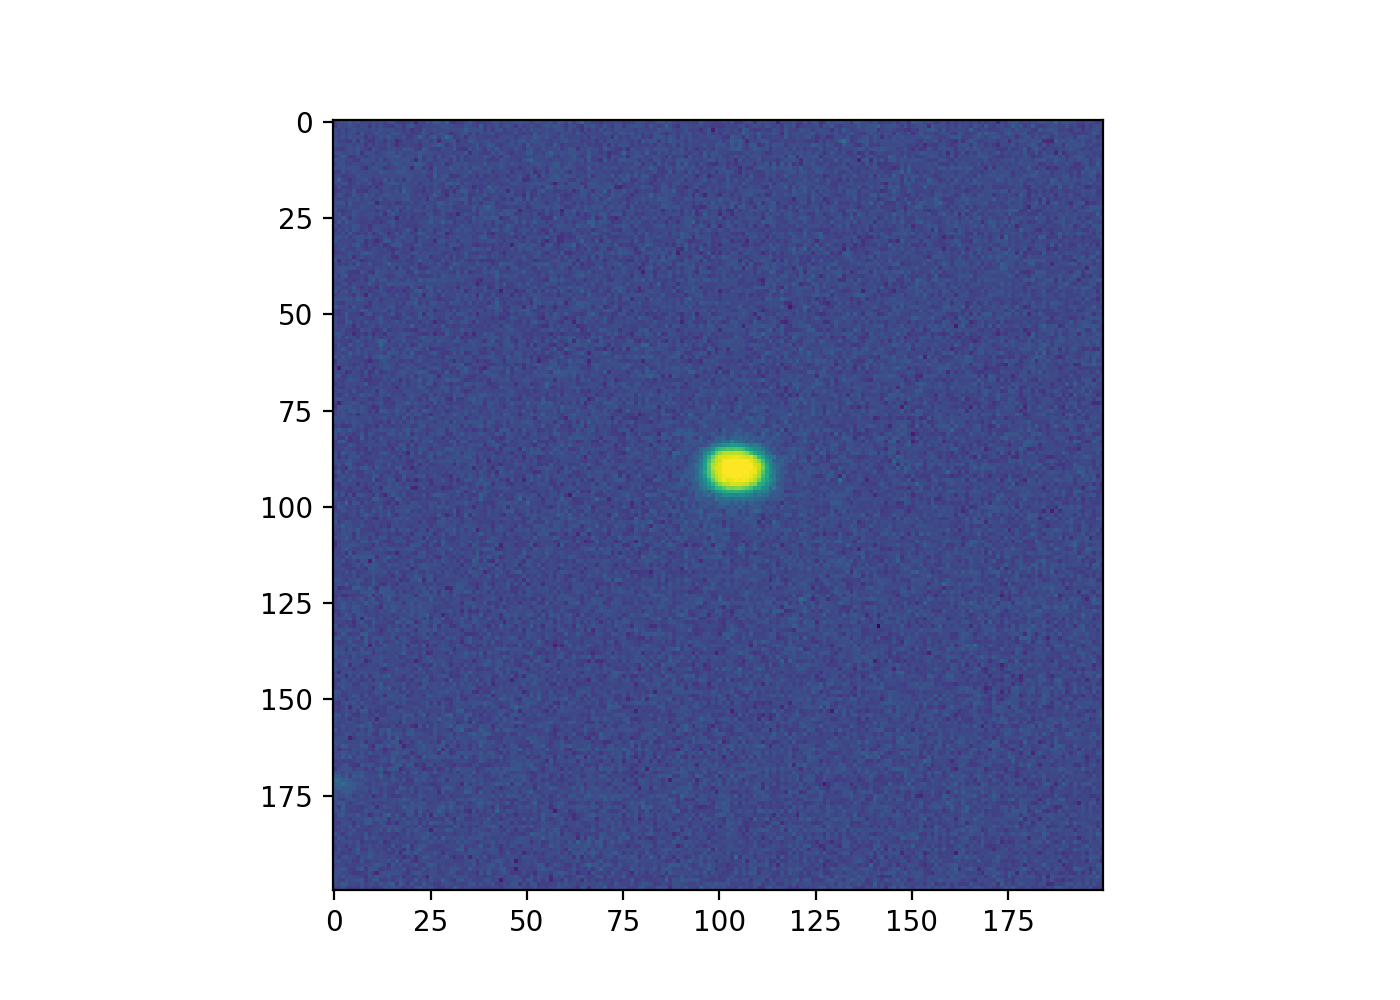

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(np.sqrt(zoomin_gray))

Finally, let us save the image with scipy to a jpg file.

In [19]:
scipy.misc.toimage(np.sqrt(zoomin_gray), cmin=0., cmax=1.).save('nebula.jpg')